In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, LSTM, Lambda
from keras.models import Sequential, Model
from keras.layers.advanced_activations import LeakyReLU

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load and preprocess data

In [2]:
ds = pd.read_csv("Modelar_UH2022_agg.txt", sep='|')
print(ds.head())

   ID  SAMPLETIME   READING  DELTA
0   0  2019-02-01  33195300  24300
1   0  2019-02-02  33218900  23600
2   0  2019-02-03  33252400  33500
3   0  2019-02-04  33277600  25200
4   0  2019-02-05  33299600  22000


In [3]:
ds = ds.sort_values(by=['ID', 'SAMPLETIME'])

Pre: replace precipitacion == 'Ip' by 0

In [4]:
temp = pd.read_csv('temperaturas_aemet.csv', decimal=',')
print(temp.head())

   Unnamed: 0.1  Unnamed: 0         dia  tavg  tmin  tmax insolacion  \
0             0           0  2019-02-01  15.4  10.6  20.2        5.1   
1             1           1  2019-02-02  12.2   9.1  15.4        7.2   
2             2           2  2019-02-03  10.2   5.9  14.6        9.8   
3             3           3  2019-02-04   9.6   3.2  15.9        9.9   
4             4           4  2019-02-05  11.3   3.4  19.2       10.1   

   precipitacion  pmax  pmin      observatorio  
0            0.6  -999  -999  ALICANTE/ALACANT  
1            0.0  -999  -999  ALICANTE/ALACANT  
2            0.0  -999  -999  ALICANTE/ALACANT  
3            0.0  -999  -999  ALICANTE/ALACANT  
4            0.0  -999  -999  ALICANTE/ALACANT  


In [5]:
temp_filter = temp[temp['observatorio'] == 'ALICANTE/ALACANT']
temp_filter = temp_filter[('2019-02-01'  <= temp_filter['dia']) & (temp_filter['dia'] <= '2020-01-31')]

In [6]:
temp_sample = temp_filter[['tavg', 'precipitacion']]

In [7]:
cluster = pd.read_csv('cluster.csv')

In [8]:
X = []
y = []

for serie in ds['ID'].unique():
    if serie% 20 == 0:
        print('reading serie:'+ str(serie))
    serie_samples = pd.Series(data=np.zeros(365),index=ds['SAMPLETIME'].unique())
    sample = ds.loc[ds['ID'] == serie, 'DELTA']
    sample.index = ds.loc[ds['ID'] == serie, 'SAMPLETIME']
    serie_samples.loc[ds.loc[(ds['ID'] == serie), 'SAMPLETIME']] = sample
    
    clus_sample = np.full(365, cluster.loc[cluster['id'] == serie,'cluster'])

    
    single_sample = np.array(np.column_stack([serie_samples,temp_sample, clus_sample]))
    X.append(single_sample[:(365-14), :])
    y.append(serie_samples[(365-14):])
    # ids.append(serie)

reading serie:0
reading serie:20
reading serie:40
reading serie:60
reading serie:80
reading serie:100
reading serie:120
reading serie:140
reading serie:160
reading serie:180
reading serie:200
reading serie:220
reading serie:240
reading serie:260
reading serie:280
reading serie:300
reading serie:320
reading serie:340
reading serie:360
reading serie:380
reading serie:400
reading serie:420
reading serie:440
reading serie:460
reading serie:480
reading serie:500
reading serie:520
reading serie:540
reading serie:560
reading serie:580
reading serie:600
reading serie:620
reading serie:640
reading serie:660
reading serie:680
reading serie:700
reading serie:720
reading serie:740
reading serie:760
reading serie:780
reading serie:800
reading serie:820
reading serie:840
reading serie:860
reading serie:880
reading serie:900
reading serie:920
reading serie:940
reading serie:960
reading serie:980
reading serie:1000
reading serie:1020
reading serie:1040
reading serie:1060
reading serie:1080
reading ser

In [9]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [10]:
def scaler(X):
    return (X - X.mean()) / X.std()

def reverse_scaler(X, X_org):
    return (X * X_org.std()) + X_org.mean()

In [11]:
def mix_max(X):
    return (X - X.min()) / (X.max() - X.min())

def reverse_mix_max(X, X_org):
    return X * (X_org.max() - X_org.min()) + X_org.min()


# Model evaluation

In [12]:
N = 14

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=X.shape[1:], return_sequences=True))
model.add(LSTM(64, input_shape=X.shape[1:], return_sequences=True))
model.add(Dense(1, activation='tanh'))
model.add(Lambda(lambda x: x[:, -N:])) #Select last N from output
model.compile(optimizer='adam', loss='mse')

2022-03-18 12:34:43.797193: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.fit(scaler(X_train), scaler(y_train), epochs=120, validation_split=0.2)

Epoch 1/120
46/46 [==============================] - 20s 428ms/step - loss: 1.0157 - val_loss: 0.0967
Epoch 2/120
46/46 [==============================] - 20s 427ms/step - loss: 1.0159 - val_loss: 0.0938
Epoch 3/120
46/46 [==============================] - 20s 425ms/step - loss: 1.0147 - val_loss: 0.0930
Epoch 4/120
46/46 [==============================] - 19s 425ms/step - loss: 1.0157 - val_loss: 0.0926
Epoch 5/120
46/46 [==============================] - 20s 425ms/step - loss: 1.0146 - val_loss: 0.0939
Epoch 6/120
46/46 [==============================] - 20s 428ms/step - loss: 1.0151 - val_loss: 0.0949
Epoch 7/120
46/46 [==============================] - 20s 425ms/step - loss: 1.0163 - val_loss: 0.0953
Epoch 8/120
46/46 [==============================] - 19s 425ms/step - loss: 1.0161 - val_loss: 0.0923
Epoch 9/120
46/46 [==============================] - 20s 427ms/step - loss: 1.0153 - val_loss: 0.0923
Epoch 10/120
46/46 [==============================] - 20s 435ms/step - loss: 1.014

In [17]:
model.evaluate(scaler(X_test), scaler(y_test))

29/29 [==============================] - 4s 153ms/step - loss: 1.2997


1.299683690071106

In [18]:
preds = model.predict(scaler(X))

In [19]:
mean_squared_error(y, reverse_scaler(preds.reshape((-1, 14)), y))

36770853000.0

In [20]:
predictions = reverse_scaler(preds,y)
predictions[predictions < 0] = 0
# predictions[X[:, 0, -1] == 5] = 0
# predictions[X[:, 0, -1] == 9] = 0 

mean_squared_error(y,predictions.reshape((-1, 14)))

36766030000.0

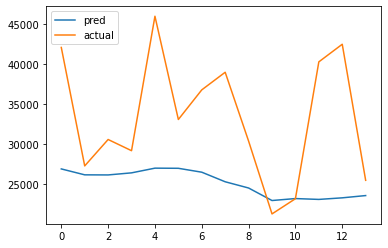

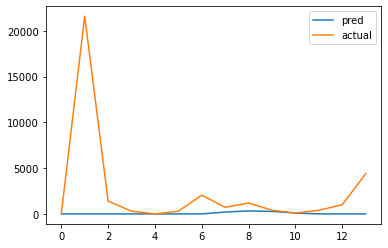

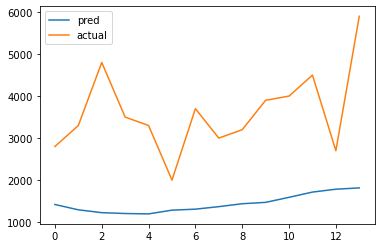

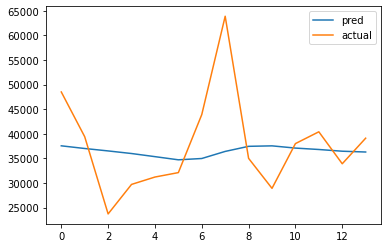

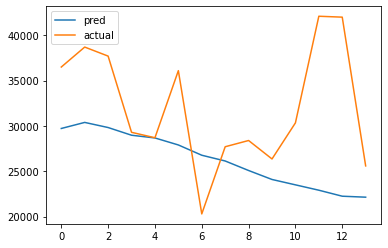

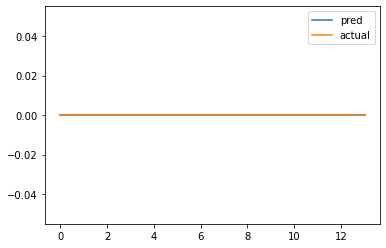

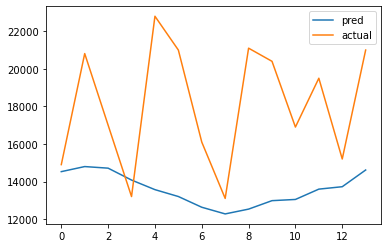

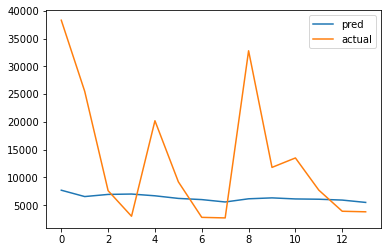

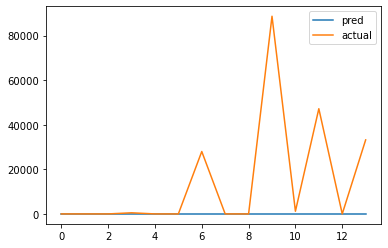

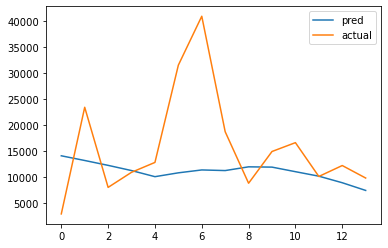

In [21]:
for i in range(10):
    plt.plot(predictions[i], label='pred')
    plt.plot(y[i], label='actual')
    plt.legend()
    plt.show()

Con temperatura y precipitación: 37186940000.0

Lo mismo a dos capas: 37084725000.0 (Millor pero no hay una gran diferencia)

Con cluster, temperatura y precipitación: 36851003000.0

Con cluster, temperatura: 36769407000.0

Jose truc: 36884816000.0

Solo cluster: 36897430000.0

Con todos los datos: 37354287000.0

Con 120 iteraciones (se me ha ido): 36770853000.0

# Predictions